In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

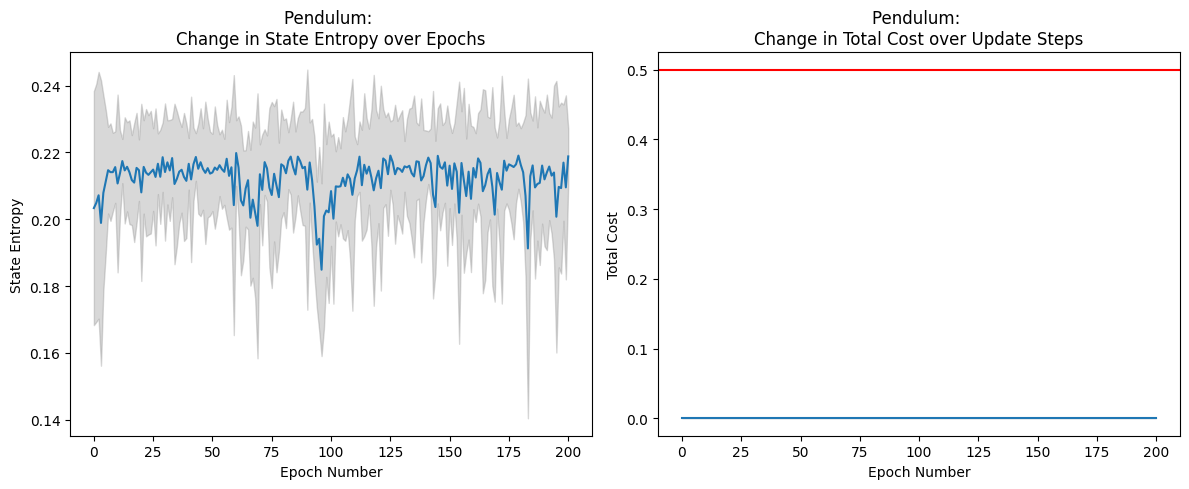

In [3]:
# df = pd.read_csv("results/MountainCarContinuous/CEM_Omega_5000/MountainCarContinuous-v0.csv", index_col = False)
df = pd.read_csv("results/Pendulum/CEM/Pendulum-v1.csv", index_col = False)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))

sns.lineplot(data = df, x = "epoch", y = "mean_entropy", ax = ax[0])
ax[0].set_xlabel("Epoch Number")
ax[0].set_ylabel("State Entropy")
ax[0].fill_between(
    df["epoch"],
    df["mean_entropy"] - df["std_entropy"],
    df["mean_entropy"] + df["std_entropy"],
    color="gray",
    alpha=0.3,
)
ax[0].set_title("Pendulum: \nChange in State Entropy over Epochs")

sns.lineplot(data = df, x = "epoch", y = "mean_cost", ax = ax[1])
ax[1].set_xlabel("Epoch Number")
ax[1].set_ylabel("Total Cost")
ax[1].fill_between(
    df["epoch"],
    df["mean_cost"] - df["std_cost"],
    df["mean_cost"] + df["std_cost"],
    color="gray",
    alpha=0.3,
)
plt.axhline(y=0.5, color="red")
# plt.axhline(y=10, color="red")
ax[1].set_title("Pendulum: \nChange in Total Cost over Update Steps")

fig.tight_layout()

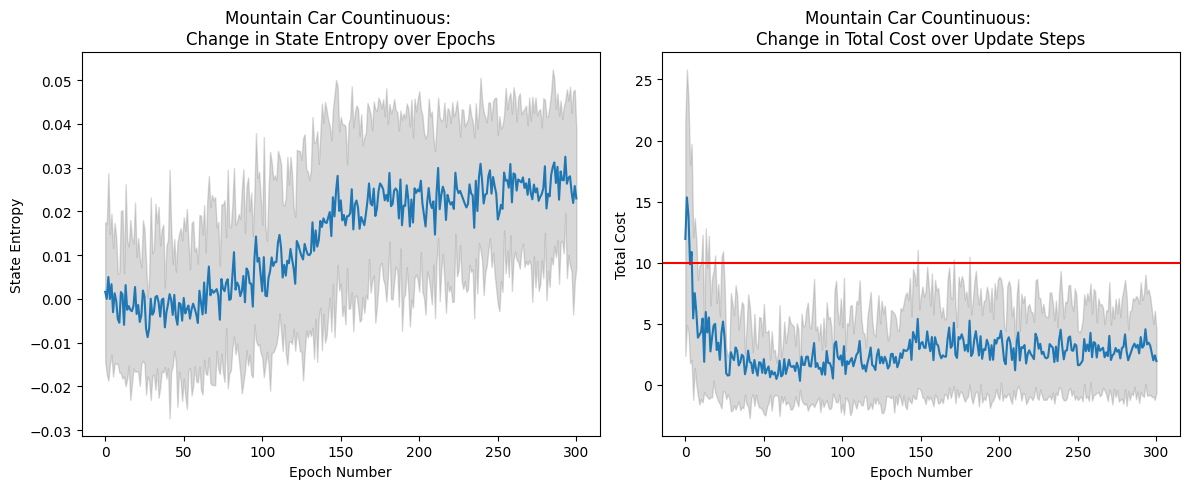

In [7]:
# df = pd.read_csv("results/MountainCarContinuous/CEM_Omega_5000/MountainCarContinuous-v0.csv", index_col = False)
df = pd.read_csv("results/MountainCarContinuous/CEM/MountainCarContinuous-v0.csv", index_col = False)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))

sns.lineplot(data = df, x = "epoch", y = "mean_entropy", ax = ax[0])
ax[0].set_xlabel("Epoch Number")
ax[0].set_ylabel("State Entropy")
ax[0].fill_between(
    df["epoch"],
    df["mean_entropy"] - df["std_entropy"],
    df["mean_entropy"] + df["std_entropy"],
    color="gray",
    alpha=0.3,
)
ax[0].set_title("Mountain Car Countinuous: \nChange in State Entropy over Epochs")

sns.lineplot(data = df, x = "epoch", y = "mean_cost", ax = ax[1])
ax[1].set_xlabel("Epoch Number")
ax[1].set_ylabel("Total Cost")
ax[1].fill_between(
    df["epoch"],
    df["mean_cost"] - df["std_cost"],
    df["mean_cost"] + df["std_cost"],
    color="gray",
    alpha=0.3,
)
# plt.axhline(y=0.5, color="red")
plt.axhline(y=10, color="red")
ax[1].set_title("Mountain Car Countinuous: \nChange in Total Cost over Update Steps")

fig.tight_layout()

<Axes: xlabel='epoch', ylabel='mean_entropy'>

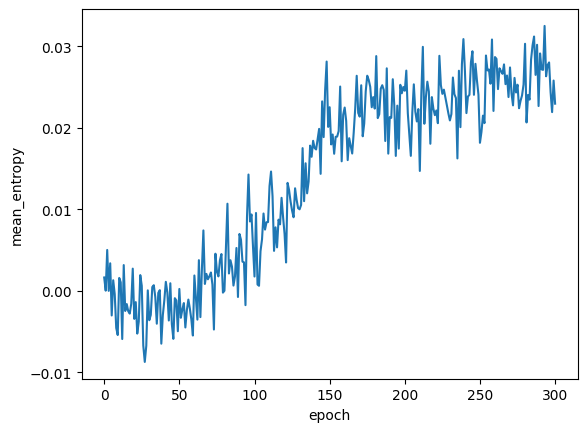

In [3]:
sns.lineplot(data=df, x="epoch", y="mean_entropy")

<Axes: xlabel='epoch', ylabel='advantage'>

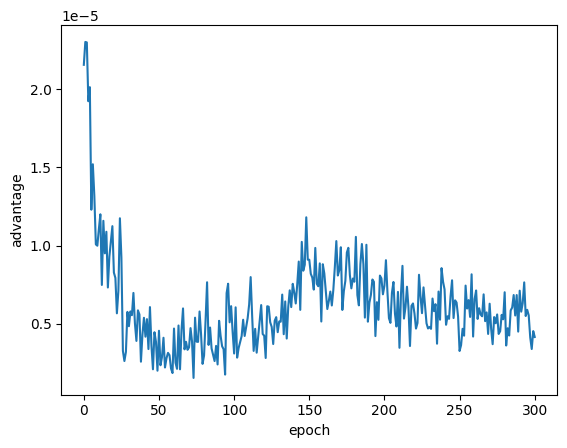

In [4]:
sns.lineplot(data=df, x="epoch", y="advantage")

<Axes: >

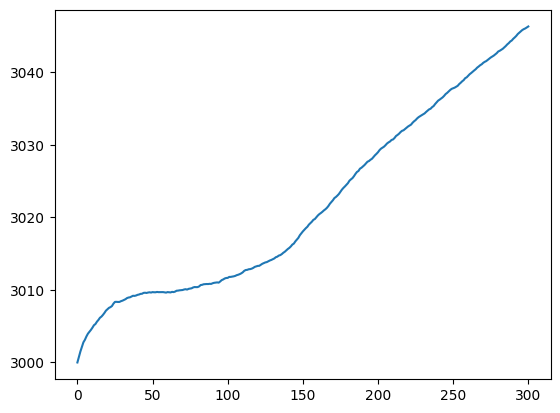

In [5]:
df["safety_weight"].plot()

<Axes: >

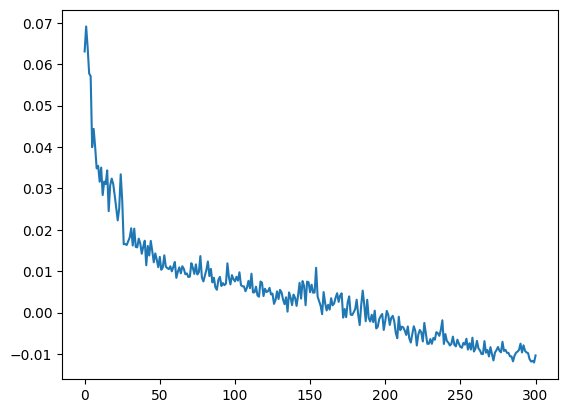

In [6]:
df["policy_loss"].plot()

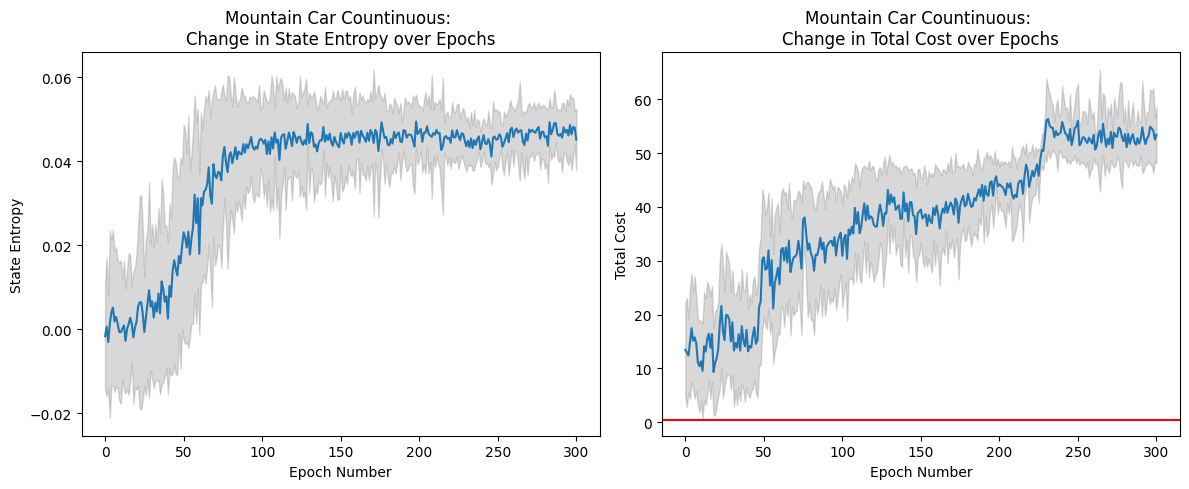

In [5]:
df = pd.read_csv("results/MountainCarContinuous/MEPOL/MountainCarContinuous-v0.csv", index_col = False)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))

sns.lineplot(data = df, x = "epoch", y = "mean_entropy", ax = ax[0])
ax[0].set_xlabel("Epoch Number")
ax[0].set_ylabel("State Entropy")
ax[0].fill_between(
    df["epoch"],
    df["mean_entropy"] - df["std_entropy"],
    df["mean_entropy"] + df["std_entropy"],
    color="gray",
    alpha=0.3,
)
ax[0].set_title("Mountain Car Countinuous: \nChange in State Entropy over Epochs")

sns.lineplot(data = df, x = "epoch", y = "mean_cost", ax = ax[1])
ax[1].set_xlabel("Epoch Number")
ax[1].set_ylabel("Total Cost")
ax[1].fill_between(
    df["epoch"],
    df["mean_cost"] - df["std_cost"],
    df["mean_cost"] + df["std_cost"],
    color="gray",
    alpha=0.3,
)
plt.axhline(y=0.5, color="red")
ax[1].set_title("Mountain Car Countinuous: \nChange in Total Cost over Epochs")

fig.tight_layout()

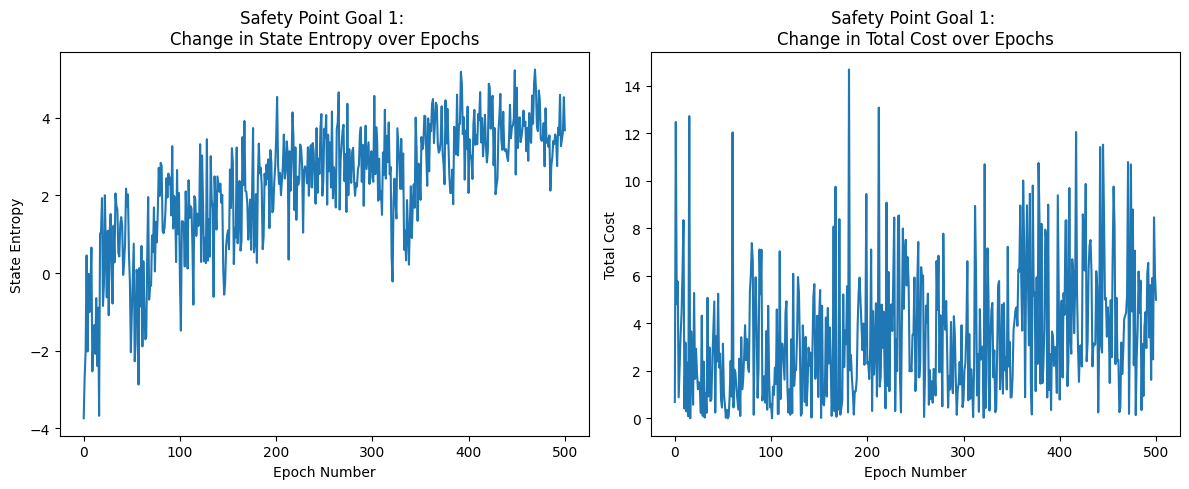

In [ ]:
df = pd.read_csv("results/SafetyPointGoal1/MEPOL/SafetyPointGoal1-v0.csv", index_col = False)
df["cost"] = abs(df["cost"])
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))

sns.lineplot(data = df, x = "epoch", y = "entropy", ax = ax[0])
ax[0].set_xlabel("Epoch Number")
ax[0].set_ylabel("State Entropy")
ax[0].set_title("Safety Point Goal 1: \nChange in State Entropy over Epochs")

sns.lineplot(data = df, x = "epoch", y = "cost", ax = ax[1])
ax[1].set_xlabel("Epoch Number")
ax[1].set_ylabel("Total Cost")
ax[1].set_title("Safety Point Goal 1: \nChange in Total Cost over Epochs")

fig.tight_layout()

In [2]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

int_type = torch.int64
float_type = torch.float64
torch.set_default_dtype(float_type)

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim=2, action_dim=1, is_discrete=False, device="cpu"):
        super().__init__()

        layers = []
        
        # 2 Hidden layers
        layers.extend((nn.Linear(state_dim, 300), nn.ReLU()))
        layers.extend((nn.Linear(300, 300), nn.ReLU()))
        self.net = nn.Sequential(*layers)

        # Output of the network: Mean and log standard deviation
        self.mean = nn.Linear(300, action_dim)
        self.log_std = nn.Parameter(-0.5 * torch.ones(action_dim, dtype = float_type))

        # Constant
        self.log_of_two_pi = torch.tensor(np.log(2 * np.pi), dtype = float_type)
        self.eps = 1e-7

        self.is_discrete = is_discrete
        self.device = device

        self.initialize_weights()

    def initialize_weights(self):
        """
        Initialize all weights using xavier uniform distribution
        """
        nn.init.xavier_uniform_(self.mean.weight)

        for l in self.net:
            if isinstance(l, nn.Linear):
                nn.init.xavier_uniform_(l.weight)

    def get_log_p(self, states, actions):
        mean, _ = self(states)
        if self.is_discrete:
            log_mean = torch.log(mean + self.eps)
            return log_mean.gather(1, actions).squeeze(-1)
        else:
            return torch.sum(
                -0.5 * (
                    self.log_of_two_pi
                    + 2 * self.log_std
                    + ((actions - mean) ** 2 / (torch.exp(self.log_std) + self.eps) ** 2)
                ), dim = 1
            )
    
    def forward(self, x, deterministic = False):
        mean = self.mean(self.net(x))
        if self.is_discrete:
            output = F.softmax(mean, dim = -1)
            return mean, output
        else:
            # Stochasticity allows for exploration in RL when not deterministic
            output = mean if deterministic else mean + torch.randn(mean.size(), dtype = float_type, device = self.device) * torch.exp(self.log_std)
            return mean, output

    def predict(self, s, deterministic=False):
        with torch.inference_mode():
            if not isinstance(s, torch.Tensor):
                s = torch.tensor(s, dtype=float_type, device=self.device)

            # Ensure correct batch shape (do not add batch dimension if already batched)
            if s.dim() == 1:  # Single state input (state_dim,)
                s = s.unsqueeze(0)  # Convert to (1, state_dim)
            
            action = self(s, deterministic=deterministic)[1]
            if self.is_discrete:
                action = torch.argmax(action, dim=-1) if deterministic else torch.multinomial(action, num_samples=1)  # Sample from distribution
            return action  # Shape: (N, action_dim) if batched, (1, action_dim) if single

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_policy_comparison(model_link, num_states=1000, seed=0):
    before_model = PolicyNetwork()
    after_model = PolicyNetwork()
    before_model.load_state_dict(torch.load(f"{model_link}/0-policy.pt"))
    after_model.load_state_dict(torch.load(f"{model_link}/300-policy.pt"))    
    torch.manual_seed(seed)
    np.random.seed(seed)

    before_model.eval()
    after_model.eval()

    # Sample random states from MountainCarContinuous state space
    positions = np.random.uniform(-1.2, 0.6, num_states)
    velocities = np.random.uniform(-0.07, 0.07, num_states)
    states = np.stack([positions, velocities], axis=1)
    states_tensor = torch.tensor(states, dtype=torch.float64)

    with torch.no_grad():
        before_mean, _ = before_model(states_tensor)
        after_mean, _ = after_model(states_tensor)

        before_std = torch.exp(before_model.log_std).cpu().numpy()
        after_std = torch.exp(after_model.log_std).cpu().numpy()

        # Sample actions from the Gaussian policy
        before_actions = before_mean + torch.randn_like(before_mean) * before_std
        after_actions = after_mean + torch.randn_like(after_mean) * after_std

    # Convert to numpy
    before_mean_np = before_mean.cpu().numpy()
    after_mean_np = after_mean.cpu().numpy()
    before_actions_np = before_actions.cpu().numpy()
    after_actions_np = after_actions.cpu().numpy()

    # Plot histograms of action samples
    plt.figure(figsize=(18, 4))

    plt.subplot(1, 3, 1)
    plt.hist(before_actions_np, bins=100, alpha=0.6, label='Before Training', density=True)
    plt.hist(after_actions_np, bins=100, alpha=0.6, label='After Training', density=True)
    plt.title("Sampled Actions (Before vs After)")
    plt.xlabel("Action")
    plt.ylabel("Density")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.hist(before_mean_np, bins=100, alpha=0.6, label='Before Training', density=True)
    plt.title("Action Means (Before)")
    plt.xlabel("Mean Action")
    plt.ylabel("Density")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.hist(after_mean_np, bins=100, alpha=0.6, label='After Training', density=True)
    plt.title("Action Means (After)")
    plt.xlabel("Mean Action")
    plt.ylabel("Density")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# visualize_policy_comparison(before, after)


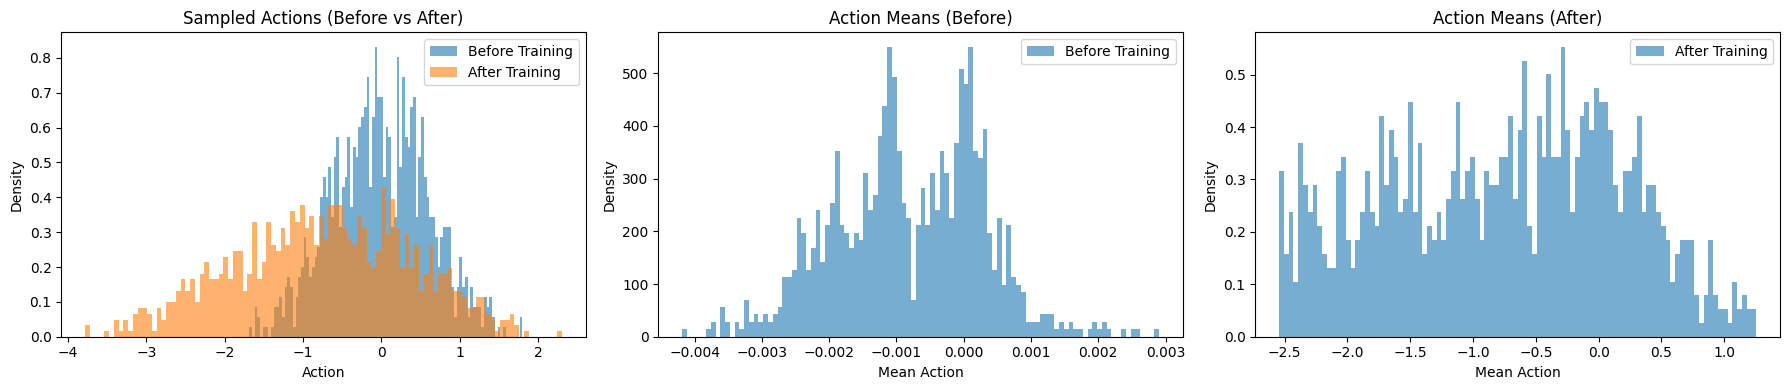

In [68]:
visualize_policy_comparison("./results/MountainCarContinuous/MEPOL")

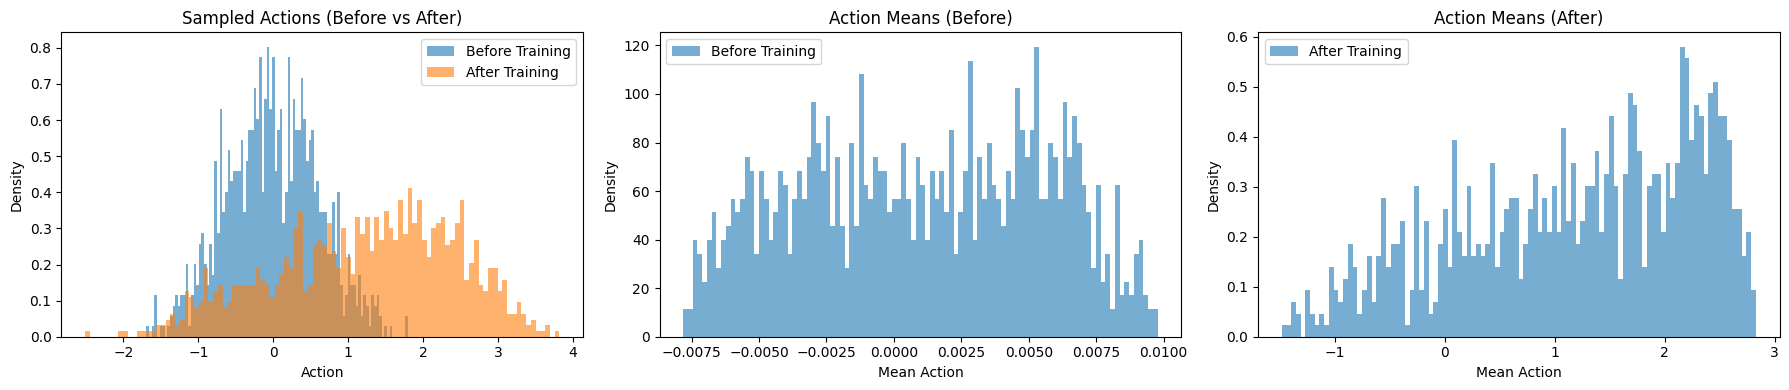

In [67]:
visualize_policy_comparison("./results/MountainCarContinuous/CEM_Omega_3000")

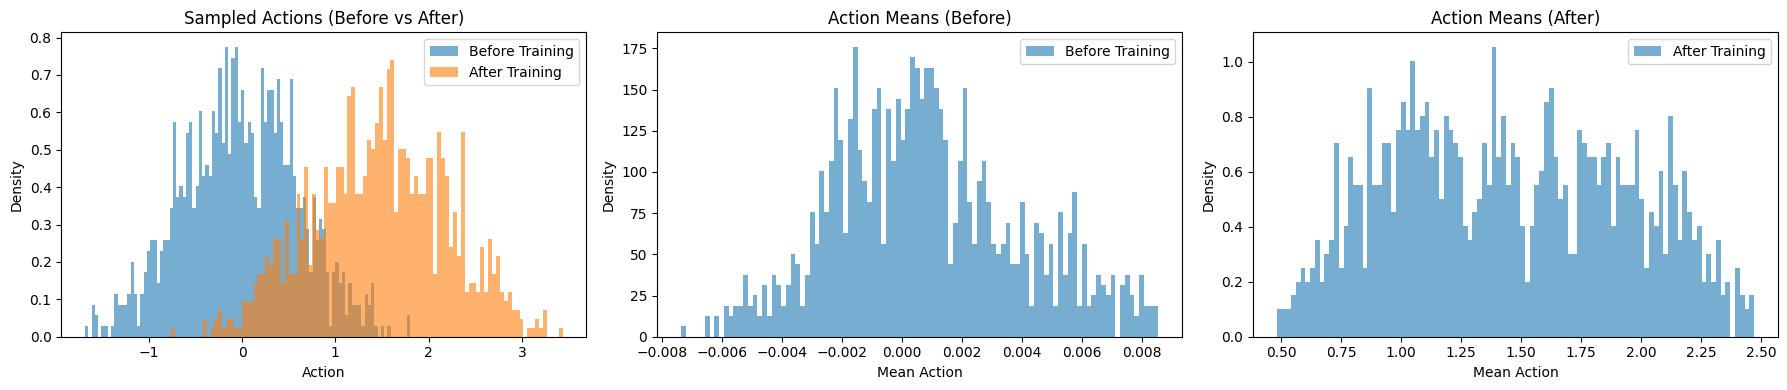

In [65]:
visualize_policy_comparison("./results/MountainCarContinuous/CEM_Omega_4000")

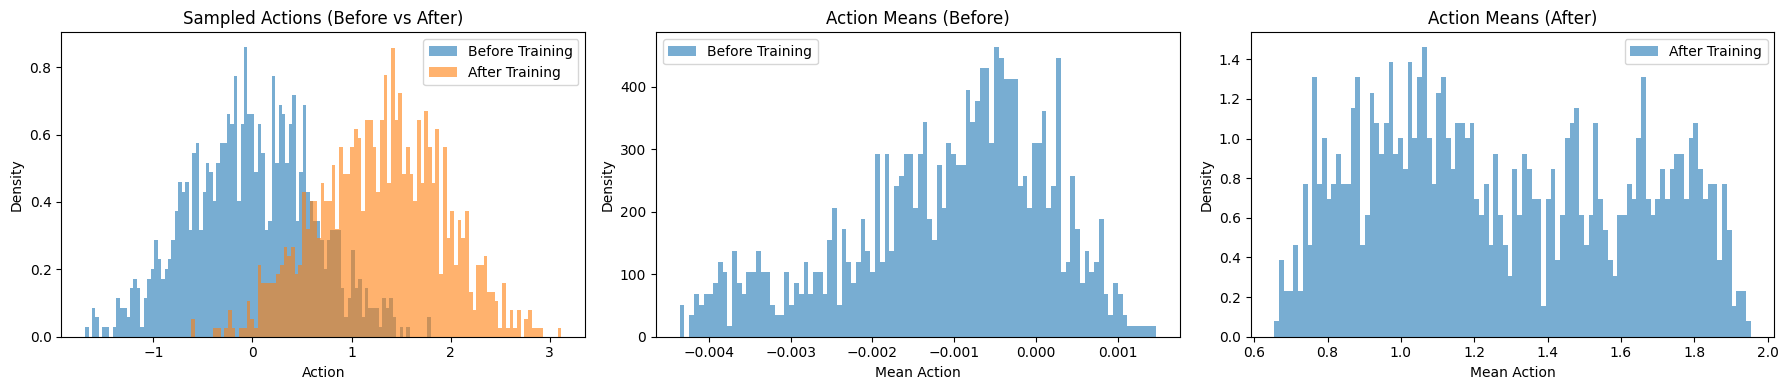

In [66]:
visualize_policy_comparison("./results/MountainCarContinuous/CEM_Omega_5000")

In [12]:
def visualize_policy_heatmap(model_link, use_mean=True, seed=0):
    before_model = PolicyNetwork()
    after_model = PolicyNetwork()
    before_model.load_state_dict(torch.load(f"{model_link}/0-policy.pt"))
    after_model.load_state_dict(torch.load(f"{model_link}/300-policy.pt"))    
    torch.manual_seed(seed)
    np.random.seed(seed)

    before_model.eval()
    after_model.eval()

    # Find some discrete states from MountainCarContinuous state space
    all_positions = np.arange(-1.2, 0.6 + 1e-8, 0.01)
    all_velocities = np.arange(-0.07, 0.07 + 1e-8, 0.001)
    grid_x, grid_y = np.meshgrid(all_positions, all_velocities)
    states = np.column_stack([grid_x.ravel(), grid_y.ravel()])
    states_tensor = torch.tensor(states, dtype=torch.float64)

    with torch.no_grad():
        before_mean, _ = before_model(states_tensor)
        after_mean, _ = after_model(states_tensor)
        before_std = torch.exp(before_model.log_std).cpu().numpy().reshape(grid_x.shape)
        after_std = torch.exp(after_model.log_std).cpu().numpy().reshape(grid_x.shape)     

    # Convert to 2D heatmaps
    before_mean_np = before_mean.cpu().numpy().reshape(grid_x.shape)
    after_mean_np = after_mean.cpu().numpy().reshape(grid_x.shape)

    safety_val = -0.6

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    if use_mean:
        im1 = ax1.imshow(before_mean_np, origin='lower', extent=[-1.2, 0.6, -0.07, 0.07], aspect='auto')
        ax1.set_title("Before Training: Action Mean")
    else:
        im1 = ax1.imshow(before_std, origin='lower', extent=[-1.2, 0.6, -0.07, 0.07], aspect='auto')   
        ax1.set_title("Before Training: Action Standard Deviation") 
    
    ax1.set_xlabel("Position")
    ax1.set_ylabel("Velocity")
    ax1.axvline(x=safety_val, color='red', linestyle='--', linewidth=2)
    fig.colorbar(im1, ax=ax1)

    if use_mean:
        im2 = ax2.imshow(after_mean_np, origin='lower', extent=[-1.2, 0.6, -0.07, 0.07], aspect='auto')
        ax2.set_title("After Training: Action Mean")
    else:
        im2 = ax2.imshow(after_std, origin='lower', extent=[-1.2, 0.6, -0.07, 0.07], aspect='auto')   
        ax2.set_title("After Training: Action Standard Deviation") 
    ax2.set_xlabel("Position")
    ax2.set_ylabel("Velocity")
    ax2.axvline(x=safety_val, color='red', linestyle='--', linewidth=2)
    fig.colorbar(im2, ax=ax2)

    plt.tight_layout()
    plt.show()


In [13]:
visualize_policy_heatmap("./results/MountainCarContinuous/CEM_Omega_3000", False)

ValueError: cannot reshape array of size 1 into shape (141,181)

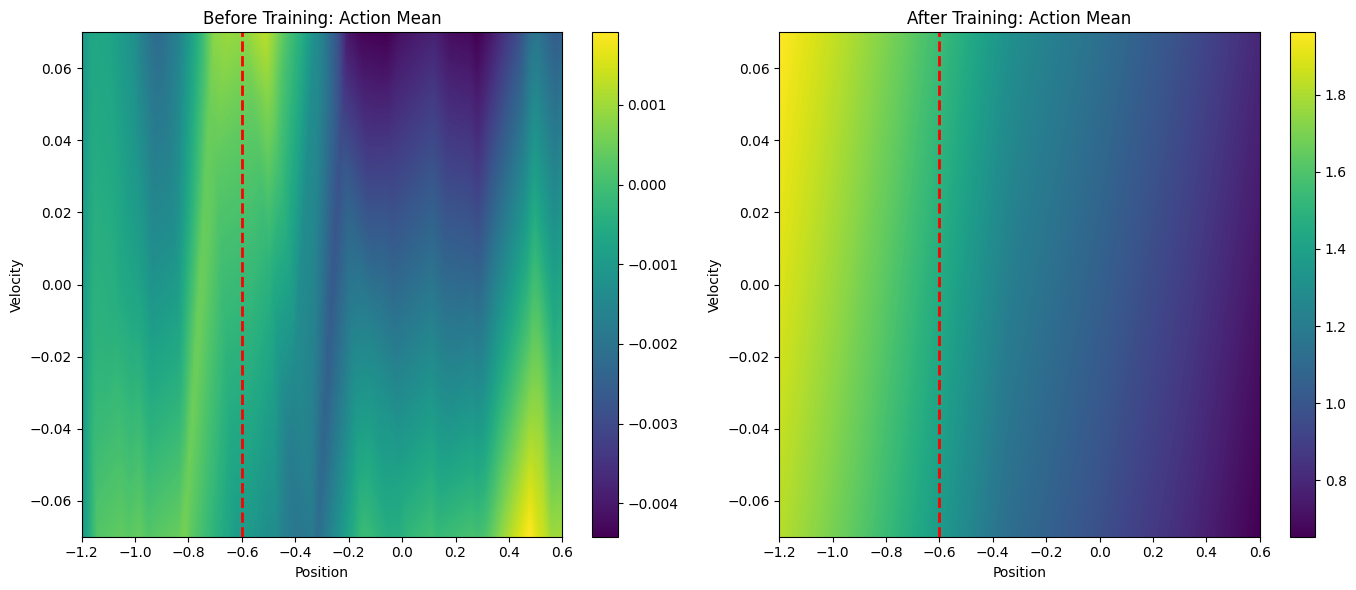

In [10]:
visualize_policy_heatmap("./results/MountainCarContinuous/CEM_Omega_5000")